# <center>Классификация животных
## Знакомство с данными
Датасет взят с [*Kaggle*](https://www.kaggle.com/datasets/alessiocorrado99/animals10)

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import os
import warnings
warnings.filterwarnings('ignore')
# less tensorflow verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import tensorflow_hub as hub
import keras
from PIL import Image
import requests
# initial state for random
RANDOM_STATE = 43
# rescale all input images
IMG_SIZE = 384
# batch size for training
BATCH_SIZE = 8
# path to data
DATA_PATH = '../data/raw-img/'
# plotly config
pio.templates.default = 'plotly_dark'
pio.renderers.default = 'png'
# display device
if tf.config.list_physical_devices('GPU'):
    print('tensorflow using GPU')
else:
    print('tensorflow using CPU')

2023-12-12 22:39:31.746633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 22:39:31.746684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 22:39:31.747341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow using GPU


Структура датасета предоставлена в следующем виде:

```
data
   └── raw-img
       ├── butterfly
       ├── cat
       ├── chicken
       ├── cow
       ├── dog
       ├── elephant
       ├── horse
       ├── sheep
       ├── spider
       └── squirrel
```

В каждой папке хранятся изображения в формате `.jpg`

Сделаем перевод папок (меток классов) с оригинального языка (итальянского) на английский. На *Kaggle* предлагается следующий словарь:

In [2]:
translate = {
    "cane": "dog",
    "cavallo": "horse", 
    "elefante": "elephant",
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

Воспользуемся словарём, чтобы переименовать метки класса. Создадим датафрейм для удобства визуализации классов с помощью диаграммы.

In [3]:
animals_dict = {'class': [], 'count': []}
for dir_name in os.listdir(DATA_PATH):
    if dir_name in translate.keys():
        os.rename(dir_name, translate[dir_name])
        animals_dict['class'].append(translate[dir_name])
        animals_dict['count'].append(len(os.listdir(DATA_PATH+translate[dir_name])))
    else:
        animals_dict['class'].append(dir_name)
        animals_dict['count'].append(len(os.listdir(DATA_PATH+dir_name)))
animals_df = pd.DataFrame(animals_dict)

Визуализируем распределение классов

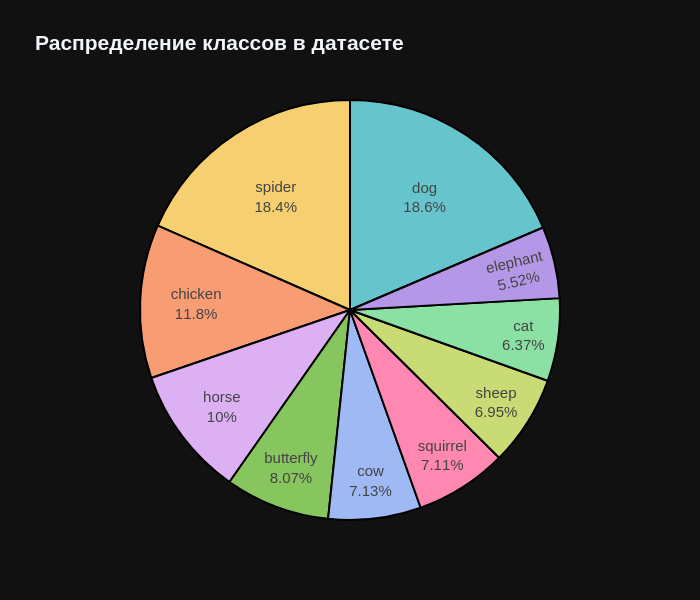

In [4]:
px.pie(
    animals_df,
    names='class',
    values='count',
    height=600,
    width=700,
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title='<b>Распределение классов в датасете</b>'
).update_traces(
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=2)), 
    textposition='inside'
).update_layout(
    showlegend=False,
    font=dict(size=15)
).show()

Классы несбалансированы, так что придётся корректировать веса классов

Разделим датасет на обучающую и валидационную выборки в соотношении 70:30. Зафиксируем параметр `image_size=(384, 384)` для того, чтобы размер изображений в датасете соответствовал необходимому требованию в используемой модели. 

In [5]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory=DATA_PATH,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.3,
    subset='both',
    seed=RANDOM_STATE
)

Found 26179 files belonging to 10 classes.
Using 18326 files for training.
Using 7853 files for validation.


Посчитаем веса классов для несбалансированной выборки с помощью *Inverse Class Frequency Method*: чем больше экземпляров класса в обучающей выборке - тем меньше его вес, и наоборот.

In [6]:
class_weights = {}
total_samples = sum([len(os.listdir(DATA_PATH+dir_label)) for dir_label in os.listdir(DATA_PATH)])
for idx, label in zip(range(10), train_ds.class_names):
    class_weights[idx] = total_samples / (2 * len(os.listdir(DATA_PATH+label)))
class_weights

{0: 6.197679924242424,
 1: 7.84742206235012,
 2: 4.225145255003228,
 3: 7.014737406216506,
 4: 2.6916512440880114,
 5: 9.052213001383127,
 6: 4.990278307281739,
 7: 7.192032967032967,
 8: 2.7151006015349513,
 9: 7.029806659505907}

Создадим функцию для получения названия классов (сейчас они закодированы с помощью *OneHotEncoder*)

In [7]:
def inverse_transform(labels:tf.Tensor):
    prediction = pd.Series(np.argmax(labels, axis=1)).map(dict(zip(range(10), train_ds.class_names)))
    return prediction

Отобразим несколько примеров из одного батча

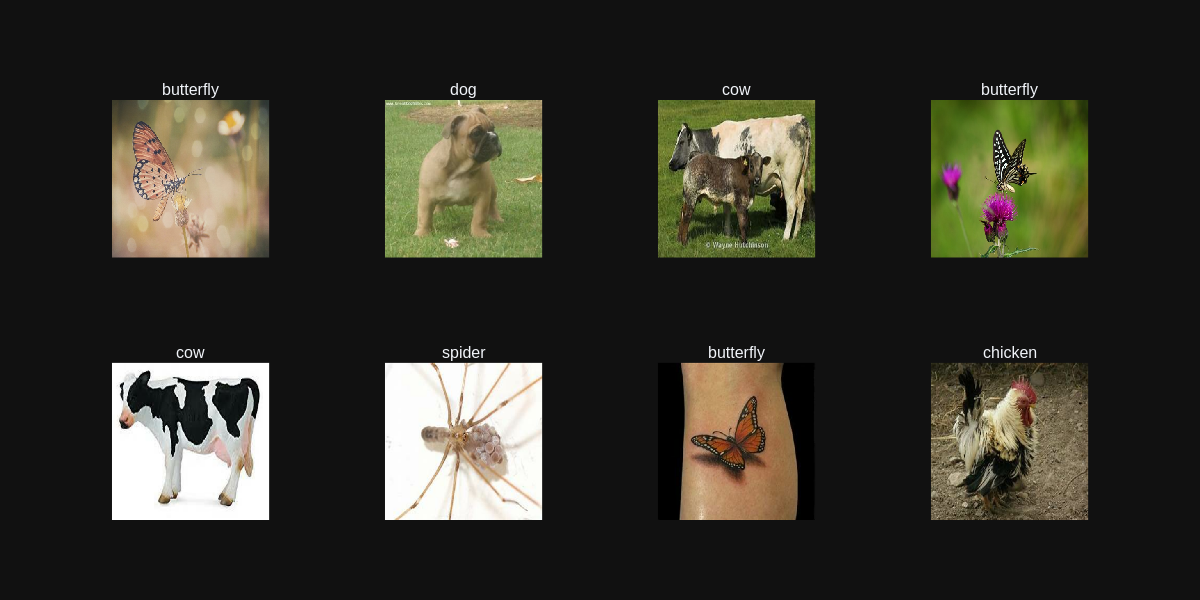

In [8]:
images, labels = next(iter(train_ds.take(1)))
grid = make_subplots(
    rows=2,
    cols=4,
    subplot_titles=inverse_transform(labels)
)
iterators = [
    range(8),
    sorted(list(range(1, 3)) * 4), 
    list(range(1, 5)) * 2
]
for n_iter, row, col in zip(*iterators):
    grid.add_trace(
        px.imshow(images[n_iter].numpy().astype("uint8")).data[0],
        row=row,
        col=col
    )
grid.update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).update_layout(
    height=600,
    width=1200
)

## DeepLearning

Создадим конволюционную сеть (*CNN*) следующей архитектуры:
1. **Предобработка входных данных**:
    * *Input*-слой - входное изображение любого размера $W \times H \times 3$ (3 канала *RGB*)
    * *Resizing*-слой - изменение размера входного изображения $W \times H \times 3$ до необходимого $384 \times 384 \times 3$ пикселей. Понадобится, когда будем делать предсказания на новых данных произвольных размеров
    * *Rescaling*-слой - нормализация пикселей до диапазона $\{0;1\}$, где $0$ - отсутствие яркости пикселя (черный цвет), $1$ - максимальная яркость пикселя (белый цвет)

2. **Аугментация обучающей выборки**:
    * *RandomFlip*-слой - добавление зеркального отображения входных данных как по вертикальной, так и по горизонтальной оси
    * *RandomRotation*-слой - добавление случайного поворота изображения в диапазоне $\{-72\degree; 72\degree\}$
3. **EfficientNet V2** - предобученная на *ImageNet 1K* [модель от *Google*](https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-s-classification/versions/2), для простой задачи подойдет легковесная версия (с суффиксом *s* (*small*) в названии модели). Именно эта модель принимает на вход тензоры размера $384 \times 384 \times 3$. Используем *Fine-tuning* для решения поставленной задачи. Выход модели: 1000 нейронов, соответствует количеству классов, на котором обучалась нейросеть

4. **Выходной слой** - 10 нейронов (соответствует количеству классов в датасете) с активацией `softmax` для получения распределения вероятностей принадлежности входных объектов к классам

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 384, 384, 3)       0         
                                                                 
 augmentation (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 efficientnet_v2_s (KerasLa  (None, 1000)              21612360  
 yer)                                                            
                                                                 
 output (Dense)              (None, 10)                10010     
                                                                 
Total params: 21622370 (82.48 MB)
Trainable params: 21468498 (81.90 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


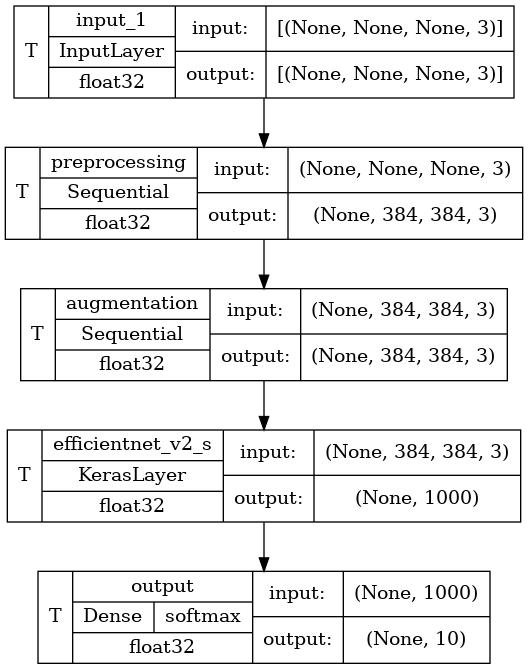

In [9]:
# Total number of classes
n_classes = len(os.listdir(DATA_PATH))
# Resizing and rescaling
preprocessing_layer = keras.Sequential([
    keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    keras.layers.Rescaling(1/255)
], name='preprocessing')
# Augmentation
augmentation_layer = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2)
], name='augmentation')
# EfficientNet V2
model_url = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-s-classification/versions/2'
efficientnet_v2_s = hub.KerasLayer(model_url, trainable=True, name='efficientnet_v2_s')
# Sequential model
model = keras.Sequential([
    keras.layers.InputLayer((None, None, 3)),
    preprocessing_layer,
    augmentation_layer,
    efficientnet_v2_s,
    keras.layers.Dense(n_classes, activation='softmax', name='output')
])
# Visualize model architecture
model.summary()
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    show_dtype=True,
    show_layer_names=True, 
    show_trainable=True
)

Компилируем модель:
1. В качестве алгоритма оптимизации возьмем <b>стохастический градиентный спуск с *Momentum* (*Adam*)</b>. Возьмем очень низкое значение `learning_rate=1e-5` для *Fine-tuning*

2. Функция потерь для минимизации - <b>логистическая функция потерь (*cross-entropy*)</b>

3. Метрики для оценки качества:
    * *Accuracy* - точность модели (количество правильных ответов из всех)
    * $F_1$-score - среднее гармоническое *Precision* и *Recall*

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.F1Score(average='macro')
    ]
)

**Инициализируем коллбек во время обучения на раннюю остановку обучения**.

Если на валидационной выборке функция потерь в течение 3-ех эпох не уменьшится хотя бы на $0.001$, то обучение прерывается, и модель откатывается к весам той эпохи, на которой функция потерь на валидационной выборке была минимальной.

In [11]:
stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=3,
    restore_best_weights=True
)

Запускаем обучение на 10-ти эпохах и сохраним наилучшую модель в файл.

In [12]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[stop_callback],
    class_weight=class_weights
)

model.save('../model/effnet.h5')

Epoch 1/10


I0000 00:00:1702378261.673672   45998 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2291/2291 [==============================] - 415s 156ms/step - loss: 3.7653 - categorical_accuracy: 0.7537 - f1_score: 0.7381 - val_loss: 0.1554 - val_categorical_accuracy: 0.9719 - val_f1_score: 0.9695
Epoch 2/10
2291/2291 [==============================] - 334s 146ms/step - loss: 1.6355 - categorical_accuracy: 0.8947 - f1_score: 0.8879 - val_loss: 0.0936 - val_categorical_accuracy: 0.9815 - val_f1_score: 0.9798
Epoch 3/10
2291/2291 [==============================] - 335s 146ms/step - loss: 1.2346 - categorical_accuracy: 0.9232 - f1_score: 0.9171 - val_loss: 0.0765 - val_categorical_accuracy: 0.9831 - val_f1_score: 0.9817
Epoch 4/10
2291/2291 [==============================] - 337s 147ms/step - loss: 1.0396 - categorical_accuracy: 0.9328 - f1_score: 0.9285 - val_loss: 0.0687 - val_categorical_accuracy: 0.9840 - val_f1_score: 0.9820
Epoch 5/10
2291/2291 [==============================] - 332s 145ms/step - loss: 0.8903 - categorical_accuracy: 0.9430 - f1_score: 0.9390 - val_loss: 0.0660

Напишем функцию для визуализации истории обучения

In [13]:
def visualize_history(history):
    epochs = len(history.history['loss'])
    history_df = pd.DataFrame({
        'loss': history.history['loss'] + history.history['val_loss'],
        'accuracy': history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'],
        'sample': ['train']*epochs + ['validation']*epochs,
        'epoch': list(range(1, epochs+1))*2
    })
    best_epoch_loss = history_df[history_df['sample'] == 'validation']['loss'].argmin() + 1
    best_epoch_acc = history_df[history_df['sample'] == 'validation']['accuracy'].argmax() + 1
    min_loss = history_df[history_df['sample'] == 'validation']['loss'].min()
    max_accuracy = history_df[history_df['sample'] == 'validation']['accuracy'].max()
    
    px.line(
        data_frame=history_df,
        x='epoch',
        y='loss',
        color='sample',
        width=900,
        height=600,
        title='История изменения функции потерь в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15)
    ).add_vline(
        x=best_epoch_loss,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=min_loss,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_loss,
        y=min_loss,
        text=f'min loss={min_loss:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=50
    ).show()
    
    px.line(
        data_frame=history_df,
        x='epoch',
        y='accuracy',
        color='sample',
        width=900,
        height=600,
        title='История изменения метрики <i>accuracy</i> в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15)
    ).add_vline(
        x=best_epoch_acc,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=max_accuracy,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_acc,
        y=max_accuracy,
        text=f'max accuracy={max_accuracy:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=-30
    ).show()

Визуализируем историю обучения модели

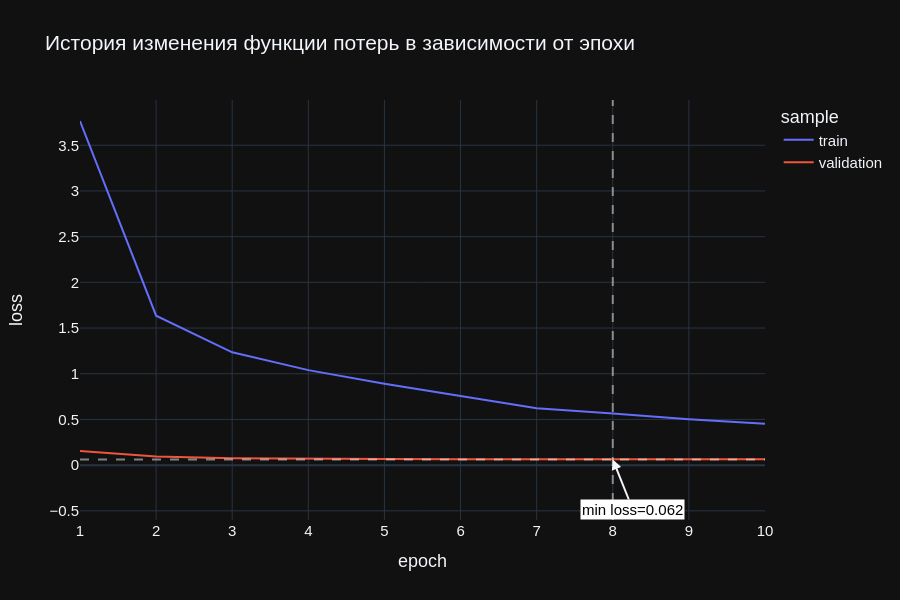

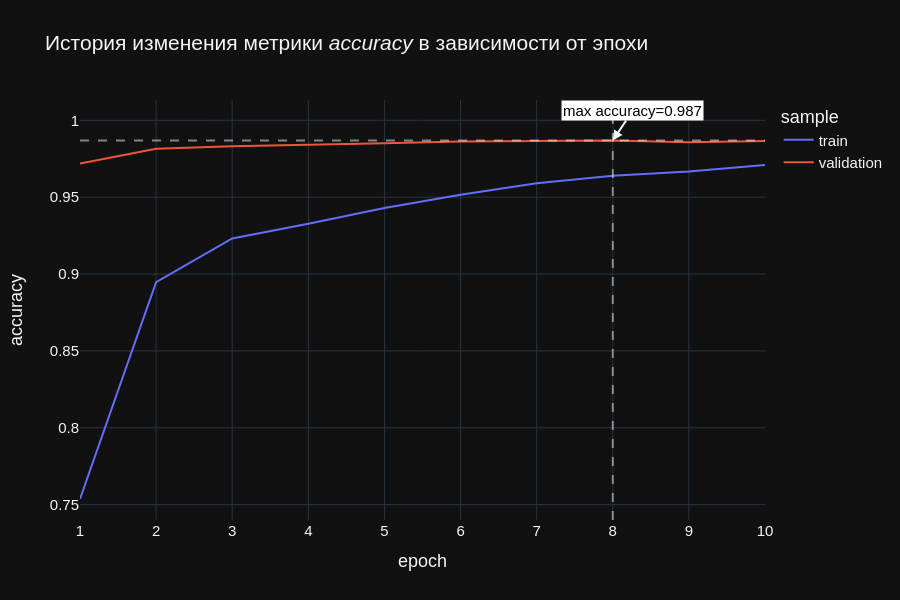

In [14]:
visualize_history(history)

Видно, что уже даже на самых первых эпохах модель показывала отличный показатель на валидационной выборке

На обучающей выборке функция потерь изначально была сильно больше, чем на валидационной. Это связано с тем, что в обучающей выборке была использована аугментация входных данных (зеркальное отображение и поворот)

На 8-й эпохе нейросеть сошлась к локальному минимуму. В итоге имеем точность $\approx 98\%$ (и $F_1$-score $\approx 0.98$) на валидационной выборке. То есть модель практически идеально отличает 10 разных животных из датасета

Протестируем на новых данных. Возьмем изображение бабочки из интернета, чтобы проверить предсказание

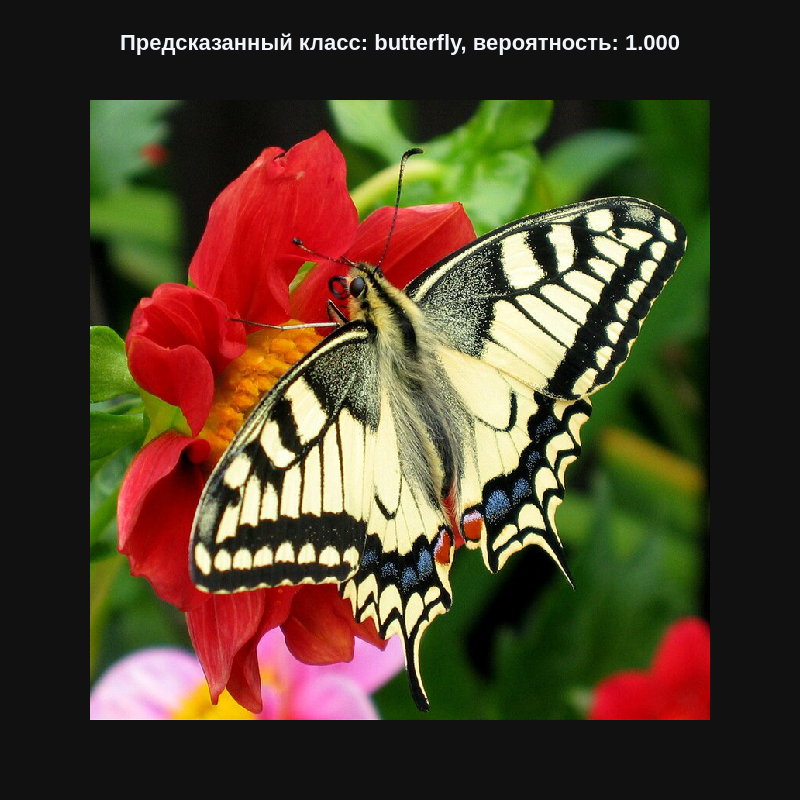

In [88]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Fesoj_-_Papilio_machaon_%28by%29.jpg/800px-Fesoj_-_Papilio_machaon_%28by%29.jpg'
# Get image from url and convert it to tensor
img = Image.open(requests.get(url, stream=True).raw)
img_tensor = tf.convert_to_tensor(img)
# Probability distribution
proba_prediction = model.predict(tf.expand_dims(img_tensor, axis=0), verbose=False)
# Most likely label
label_prediction = inverse_transform(proba_prediction)[0]
# Probability of label
max_proba_label = proba_prediction.max()
# Visualize 
px.imshow(
    img_tensor,
    title=f'<b>Предсказанный класс: {label_prediction}, вероятность: {max_proba_label:.3f}</b>',
    height=img_tensor.shape[0],
    width=img_tensor.shape[1]
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).update_layout(
    title_x=0.5,
    font=dict(size=16)
)

Благодаря всего 8-ми эпохам *Fine-tuning* получилось создать модель, которая практически идеально классифицирует одного из 10 животных по изображению.